In [2]:
addprocs(15);

In [3]:
workers()

15-element Array{Int64,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16

Load required modules

In [4]:
@everywhere using QR, HD

In [5]:
@everywhere using HDF5, JLD  # loading data

In [6]:
using PyPlot  # plotting
@everywhere using Distributions

INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...


In [7]:
@everywhere using Mosek

## Direct Estimation

In [29]:
@everywhere function generate_data(n, p, s, noiseType, corType)
    
    if corType == 1
      # equal correlation
      Sigma = 0.5 * ones(p,p) + 0.2 * eye(p)
    elseif corType == 2
      # toeplitz
      rho = 0.8
      Sigma = zeros(Float64, p,p)
      for a=1:p
        for b=a:p
          t = rho^abs(a-b)
          Sigma[a,b] = t
          Sigma[b,a] = t
        end
      end
    elseif corType == 3
      # toeplitz
      rho = 0.1
      Sigma = zeros(Float64, p,p)
      for a=1:p
        for b=a:p
          t = rho^abs(a-b)
          Sigma[a,b] = t
          Sigma[b,a] = t
        end
      end
    else
      error("Not implemented")
    end

    sqSigma = sqrtm(Sigma)

    beta = linspace(1., 0.5, s)
    X = randn(n, p) * sqSigma    
    if noiseType == 1
      errTerm = randn(n)
    elseif noiseType == 2
      tdist = TDist(1)
      errTerm = rand(tdist, n)
    else
      error("Not implemented")
    end

    Y = X[:,1:s] * beta + errTerm 
    
    (Y, X, beta)
end

In [60]:
@everywhere function debiased_estimate(
    rep, lambdaQRArr, lambdaLassoArr, tau, indJ,
    n, p, s, noiseType, corType
    )
    
    srand(rep)
    Y, X, true_beta = generate_data(n, p, s, noiseType, corType)
    
    solver = Mosek.MosekSolver(LOG=0,
                     OPTIMIZER=Mosek.MSK_OPTIMIZER_FREE_SIMPLEX,
                     PRESOLVE_USE=Mosek.MSK_PRESOLVE_MODE_OFF)
    qr_problem = QRProblem(solver, X, Y)

    qr_path = compute_qr_path!(qr_problem, lambdaQRArr, tau; max_hat_s=20)
    qr_refit_path = compute_qr_path_refit!(qr_problem, qr_path)
    
    XX = cov(X, corrected=false, mean=0.)
    Xy = zeros(Float64, p)    
    Xy[indJ] = 1.
    lasso_var_path = compute_lasso_path(XX, Xy, lambdaLassoArr; max_hat_s=10)
    
    lasso_refit_var_path = compute_lasso_path_refit(lasso_var_path, XX, Xy)
    
    qr_path, qr_refit_path, lasso_var_path, lasso_refit_var_path
end    

In [66]:
@everywhere function computeF(rep) 
    lambdaQRArr = logspace(log10(0.4), log10(0.05), 30)
    lambdaLassoArr = logspace(log10(0.8), log10(0.1), 30)
    tau = 0.5
    indJ = 10    
    
    n = 1000
    p = 50
    s = 10
    corType = 2
    noiseType = 1
    
    @time debiased_estimate(
        rep, lambdaQRArr, lambdaLassoArr, tau, indJ,
        n, p, s, noiseType, corType)
end

In [67]:
res = pmap(computeF, [1]);

	From worker 2:	Solving 1/30    nnz ==  0
	From worker 2:	Solving 11/30    nnz ==  10
	From worker 2:	Solving 21/30    nnz ==  10
	From worker 2:	elapsed time: 1.34182638 seconds (147443568 bytes allocated, 13.80% gc time)


In [69]:
res[1][4][[1,9,10,11]]

4-element Array{Float64,1}:
  0.0824361
 -2.25674  
  4.67504  
 -2.25251  

## Collect Results

In [8]:
@everywhere function compute_coverage_refit_known_f(
    lambdaQRArr, lambdaLassoArr, tauArr, rep, indTau, indJ;
    simPath = "/scratch/midway/mkolar/qr", 
    corType = 1,
    noiseType = 1
    )    
    
    tau = tauArr[indTau]
    if noiseType == 1
        err_d = Normal()
    elseif noiseType == 2
        err_d = TDist(1)
    elseif noiseType == 3
        err_d = TDist(2)
    end
    spF = 1. / pdf(err_d, quantile(err_d, tau))
    
    # load data
    data = JLD.load("$(simPath)/data/data_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld")
    X = data["X"]
    Y = data["Y"]
    s = data["s"]
    true_beta = data["beta"]
    
    if indJ > s
        true_coef = 0.
    else
        true_coef = true_beta[indJ]
    end
    
    n, p = size(X)
    
    hSigma = X'*X / n
    
    residuals = Array(Float64, n)
    gradient = Array(Float64, p)
    
    num_covered = zeros(length(lambdaQRArr), length(lambdaLassoArr))
    num_appear = zeros(length(lambdaQRArr), length(lambdaLassoArr))
    
    # load result rep --> result
    if isfile("$(simPath)/path_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld")
        result = JLD.load("$(simPath)/path_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld")
    else
        return (num_appear, num_covered)
    end
        
    cur_qr_path = result["qr_tau_path"][indTau]
    cur_lasso_path = result["lasso_var_path"][indJ]

    for indL1=1:length(cur_qr_path.lambdaArr)        
        estim_support_qr = find(cur_qr_path.beta[indL1])
        refit_qr = result["qr_refit_tau_path"][indTau][estim_support_qr]
        
        for indL2=1:length(cur_lasso_path.lambdaArr)
            estim_support_lasso = find(cur_lasso_path.beta[indL2])
            refit_lasso = result["lasso_refit_var_path"][indJ][estim_support_lasso]

            for i=1:n
                tmp = Y[i] - refit_qr.intercept - dot(vec(X[i, refit_qr.beta.rowval]), refit_qr.beta.nzval)
                if tmp < 0.
                    residuals[i] = tau - 1
                else
                    residuals[i] = tau
                end
            end
            At_mul_B!(gradient, X, residuals)              
            
            hb_debias = refit_qr.beta[indJ] + dot(refit_lasso, gradient[estim_support_lasso]) * spF / n
            eSigma = dot(refit_lasso, hSigma[estim_support_lasso, estim_support_lasso] * refit_lasso) * tau * (1 - tau) * spF^2 / n
            lb = hb_debias - 1.96 * sqrt( eSigma )
            ub = hb_debias + 1.96 * sqrt( eSigma )            
            
            num_appear[indL1, indL2] += 1
            if (lb < true_coef < ub)
                num_covered[indL1, indL2] += 1
            end
            
        end
    end
    
    (num_covered, num_appear)
end

In [75]:
@everywhere function compute_refit_test(
    lambdaQRArr, lambdaLassoArr, tauArr, rep, indTau, indJ,
    indL1, indL2;
    simPath = "/scratch/midway/mkolar/qr", 
    corType = 1,
    noiseType = 1
    )    
    
    tau = tauArr[indTau]
    if noiseType == 1
        err_d = Normal()
    elseif noiseType == 2
        err_d = TDist(1)
    elseif noiseType == 3
        err_d = TDist(2)
    end
    spF = 1. / pdf(err_d, quantile(err_d, tau))
    
    # load data
    data = JLD.load("$(simPath)/data/data_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld")
    X = data["X"]
    Y = data["Y"]
    s = data["s"]
    true_beta = data["beta"]
    
    if indJ > s
        true_coef = 0.
    else
        true_coef = true_beta[indJ]
    end
    
    n, p = size(X)
    
    hSigma = X'*X / n
    
    residuals = Array(Float64, n)
    gradient = Array(Float64, p)
        
    # load result rep --> result
    if isfile("$(simPath)/path_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld")
        result = JLD.load("$(simPath)/path_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld")
    else
        return (0., 0)
    end
        
    cur_qr_path = result["qr_tau_path"][indTau]
    cur_lasso_path = result["lasso_var_path"][indJ]
    
    estim_support_qr = find(cur_qr_path.beta[indL1])
    refit_qr = result["qr_refit_tau_path"][indTau][estim_support_qr]

    estim_support_lasso = find(cur_lasso_path.beta[indL2])
    refit_lasso = result["lasso_refit_var_path"][indJ][estim_support_lasso]

    for i=1:n
        tmp = Y[i] - refit_qr.intercept - dot(vec(X[i, refit_qr.beta.rowval]), refit_qr.beta.nzval)
        if tmp < 0.
            residuals[i] = tau - 1
        else
            residuals[i] = tau
        end
    end
    At_mul_B!(gradient, X, residuals)              

    hb_debias = refit_qr.beta[indJ] + dot(refit_lasso, gradient[estim_support_lasso]) * spF / n
    eSigma = dot(refit_lasso, hSigma[estim_support_lasso, estim_support_lasso] * refit_lasso) * tau * (1 - tau) * spF^2 / n
    
    (hb_debias - true_coef) / sqrt( eSigma ), 1
end

In [94]:
@everywhere function collect_test(rep) 
    tauArr = [0.1:0.02:0.9]
    lambdaQRArr = logspace(log10(0.4), log10(0.05), 30)
    lambdaLassoArr = logspace(log10(0.8), log10(0.1), 30)

    indTau = findfirst(tauArr, 0.5)
    indJ = 15
    
    indL1 = 23
    indL2 = 10
    
    compute_refit_test(
      lambdaQRArr, lambdaLassoArr, tauArr, rep, indTau, indJ, indL1, indL2;
      simPath = "/project/mkolar/qr",
      corType = 3,
      noiseType = 2)
end
numTests=450
collect_res = pmap(collect_test, [1:numTests]);
# collect_test(3)

450-element Array{Any,1}:
 (1.0448337207358207,1)    
 (1.2552396725116994,1)    
 (-0.003740868259259122,1) 
 (1.058531417324458,1)     
 (0.6597156524014707,1)    
 (0.6494980374181644,1)    
 (-0.08549854278321681,1)  
 (-0.7624652766062996,1)   
 (-1.4099305849714623,1)   
 (-0.9001679094990979,1)   
 (0.9087681208405263,1)    
 (-0.08358000280173788,1)  
 (-0.0023136670414147537,1)
 ⋮                         
 (-1.3330511579799185,1)   
 (-0.02166843769020802,1)  
 (-0.5376488655678464,1)   
 (0.9788674849023267,1)    
 (0.5813098032004163,1)    
 (1.3665888213917736,1)    
 (0.8404186119034418,1)    
 (-1.0038597809425915,1)   
 (-0.8746931261909036,1)   
 (1.0067968403450094,1)    
 (-0.5150207920121116,1)   
 (0.4568724064286059,1)    

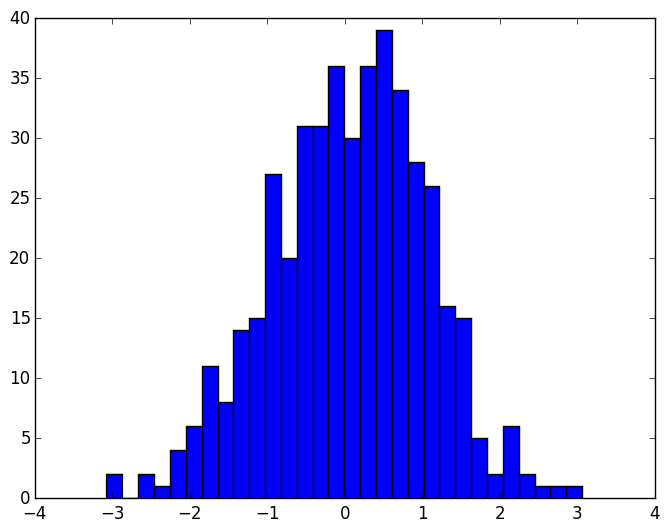

([2.0,0.0,2.0,1.0,4.0,6.0,11.0,8.0,14.0,15.0  …  26.0,16.0,15.0,5.0,2.0,6.0,2.0,1.0,1.0,1.0],[-3.07529,-2.87073,-2.66618,-2.46162,-2.25707,-2.05251,-1.84796,-1.6434,-1.43885,-1.23429  …  1.22036,1.42492,1.62947,1.83403,2.03858,2.24314,2.44769,2.65225,2.8568,3.06135],{PyObject <matplotlib.patches.Rectangle object at 0x7ff6591083d0>,PyObject <matplotlib.patches.Rectangle object at 0x7ff659108a10>,PyObject <matplotlib.patches.Rectangle object at 0x7ff659108f10>,PyObject <matplotlib.patches.Rectangle object at 0x7ff659116750>,PyObject <matplotlib.patches.Rectangle object at 0x7ff659116dd0>,PyObject <matplotlib.patches.Rectangle object at 0x7ff6590a3490>,PyObject <matplotlib.patches.Rectangle object at 0x7ff6590a3b10>,PyObject <matplotlib.patches.Rectangle object at 0x7ff6590b01d0>,PyObject <matplotlib.patches.Rectangle object at 0x7ff6590b0850>,PyObject <matplotlib.patches.Rectangle object at 0x7ff6590b0ed0>  …  PyObject <matplotlib.patches.Rectangle object at 0x7ff659074790>,PyObject <mat

In [95]:
res = zeros(numTests)
numNonZero = 0
for i=1:numTests
  if collect_res[i] != BoundsError() && collect_res[i][2] == 1
     numNonZero += 1
     res[numNonZero] = collect_res[i][1]
  end
end
res = res[1:numNonZero]
plt.hist(res, min(30,numTests))

numNonZero => 450


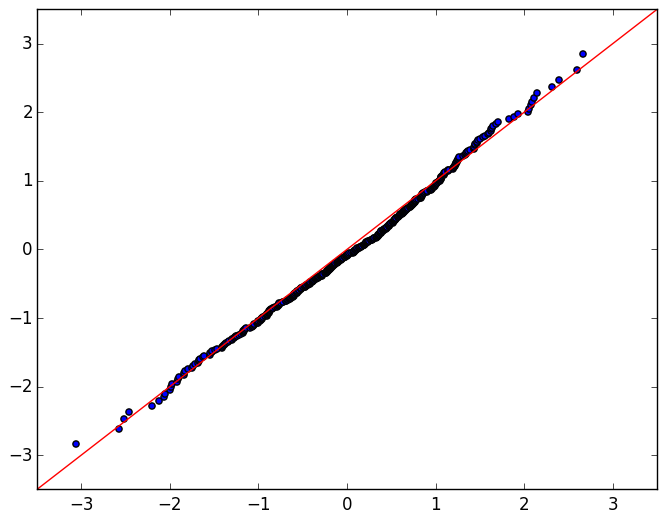

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff658f65f90>

In [96]:

qq = qqbuild(res, Normal())
scatter(qq.qx, qq.qy)
ax = gca()
ax[:set_ylim]([-3.5, 3.5])
ax[:set_xlim]([-3.5, 3.5])
xx=-3.5:0.01:3.5
plot(xx,xx, color="red")


In [17]:
num_covered = zeros(30, 30)
num_appear = zeros(30, 30)
for i=1:500
    num_covered = num_covered + collect_res[i][1]
    num_appear = num_appear + collect_res[i][2]
end
@show (num_covered ./ num_appear)[24, 16]

(num_covered ./ num_appear)[24,16] => 0.9558823529411765


0.9558823529411765

In [22]:
@everywhere function compute_coverage_known_f(
    lambdaQRArr, lambdaLassoArr, tauArr, rep, indTau, indJ;
    simPath = "/scratch/midway/mkolar/qr", 
    corType = 1,
    noiseType = 1
    )    
    
    tau = tauArr[indTau]
    err_d = Normal()
    spF = 1. / pdf(err_d, 0 )
    
    # load data
    data = JLD.load("$(simPath)/data/data_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld")
    X = data["X"]
    Y = data["Y"]
    s = data["s"]
    true_beta = data["beta"]
    
    if indJ > s
        true_coef = 0.
    else
        true_coef = true_beta[indJ]
    end
    
    n, p = size(X)
    
    hSigma = X'*X / n
    
    residuals = Array(Float64, n)
    gradient = Array(Float64, p)
    
    num_covered = zeros(length(lambdaQRArr), length(lambdaLassoArr))
    num_appear = zeros(length(lambdaQRArr), length(lambdaLassoArr))
    
    # load result rep --> result
    if isfile("$(simPath)/path_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld")
        result = JLD.load("$(simPath)/path_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld")
    else
        return (num_appear, num_covered)
    end
        
    cur_qr_path = result["qr_tau_path"][indTau]
    cur_lasso_path = result["lasso_var_path"][indJ]

    for indL1=1:length(cur_qr_path.lambdaArr)        
         estim_support_qr = find(cur_qr_path.beta[indL1])
#         refit_qr = result["qr_refit_tau_path"][indTau][estim_support_qr]
        
        for indL2=1:length(cur_lasso_path.lambdaArr)
            estim_support_lasso = find(cur_lasso_path.beta[indL2])
#             refit_lasso = result["lasso_refit_var_path"][indJ][estim_support_lasso]

            for i=1:n
                tmp = Y[i] - cur_qr_path.intercept[indL1] - dot(vec(X[i, estim_support_qr]), cur_qr_path.beta[indL1].nzval)
                if tmp < 0.
                    residuals[i] = tau - 1
                else
                    residuals[i] = tau
                end
            end
            At_mul_B!(gradient, X, residuals)              
            
            hb_debias = cur_qr_path.beta[indL1] + dot(cur_lasso_path.beta[indL2].nzval, gradient[estim_support_lasso]) * spF / n
            eSigma = dot(cur_lasso_path.beta[indL2].nzval, hSigma[estim_support_lasso,estim_support_lasso] * cur_lasso_path.beta[indL2].nzval) * tau * (1 - tau) * spF^2 / n
            lb = hb_debias - 1.96 * sqrt( eSigma )
            ub = hb_debias + 1.96 * sqrt( eSigma )            
            
            num_appear[indL1, indL2] += 1
            if (lb < true_coef < ub)
                num_covered[indL1, indL2] += 1
            end
            
        end
    end
    
    (num_covered, num_appear)
end

# Sparsity function estimation

Plot estimated sparsity function for a fixed h over a large number of simulation runs.

In [7]:
@everywhere function estimated_spF(rep, numTau, numL;
    diffH = 1,
    dataPath = "/project/mkolar/qr", 
    simPath = "/project/mkolar/qr_spF", 
    corType = 2,
    noiseType = 1
    )   
    
#     @show numTau, numL
    
    estim_spf = zeros(Float64, numTau, numL)
    estim_debias_spf = zeros(Float64, numTau, numL)
    estim_oracle_spf = zeros(Float64, numTau, 1)
    num_res = zeros(Float64, numTau, numL)
    num_res_o = zeros(Float64, numTau, 1)    
    
    # load data
    data = JLD.load("$(dataPath)/data/data_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld")
    Y = data["Y"]
    
    n = length(Y)    
    
    # load result rep --> result
    if isfile("$(simPath)/path_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld")
        result = JLD.load("$(simPath)/path_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld")
        result_o = JLD.load("$(simPath)/path_rep_$(rep)_cor_$(corType)_noise_$(noiseType)_refit.jld")
    else
        return (estim_spf, estim_debias_spf, estim_oracle_spf, num_res, num_res_o)
    end
        
    for indTau=2*diffH+1:numTau-2*diffH
        lambdaArr = result["qr_tau_path"][indTau].lambdaArr
        
        for indL=1:length(lambdaArr)
            
            a1 = vec( result["qr_tau_path"][indTau+2*diffH].xi[indL, :] )
            a2 = vec( result["qr_tau_path"][indTau].xi[indL, :] )
            a3 = vec( result["qr_tau_path"][indTau-2*diffH].xi[indL, :] )
            estim_spf[indTau, indL] = -dot(Y, a1 - 2*a2 + a3) / 4 / (0.02*diffH)^2     
            
            beta1 = vec( result["qr_tau_path"][indTau+2*diffH].beta[indL])
            estim_support_qr = find(beta1)
            a1 = vec( result["qr_refit_tau_path"][indTau+2*diffH][estim_support_qr].xi ) 

            estim_support_qr = find(vec( result["qr_tau_path"][indTau].beta[indL]))
            a2 = vec( result["qr_refit_tau_path"][indTau][estim_support_qr].xi )
            
            estim_support_qr = find(vec( result["qr_tau_path"][indTau-2*diffH].beta[indL]))
            a3 = vec( result["qr_refit_tau_path"][indTau-2*diffH][estim_support_qr].xi )
            
            estim_debias_spf[indTau, indL] = -dot(Y, a1 - 2*a2 + a3) / 4 / (0.02*diffH)^2 
            num_res[indTau, indL] += 1
        end

        a1 = vec( result_o["qr_tau_path"][indTau+2*diffH].xi[1, :] )
        a2 = vec( result_o["qr_tau_path"][indTau].xi[1, :] )
        a3 = vec( result_o["qr_tau_path"][indTau-2*diffH].xi[1, :] )
        estim_oracle_spf[indTau, 1] = -dot(Y, a1 - 2*a2 + a3) / 4 / (0.02*diffH)^2 
        
        num_res_o[indTau, 1] += 1
    end

    (estim_spf, estim_debias_spf, estim_oracle_spf, num_res, num_res_o)
end

Oracle estimate for the sparsity function

In [27]:
@everywhere function collect_spF(rep) 
    tauArr = [0.1:0.02:0.9]
    lambdaArr = logspace(log10(0.4), log10(0.05), 30)

    diffH = 2
    dataPath = "/project/mkolar/qr" 
    simPath = "/project/mkolar/qr_spF"
    corType = 2
    noiseType = 1
    
    estimated_spF(
        rep, length(tauArr), length(lambdaArr); 
        diffH = diffH,    
        dataPath = dataPath,
        simPath = simPath, 
        corType = corType,
        noiseType = noiseType)    
end
collect_res = pmap(collect_spF, [1:200]);

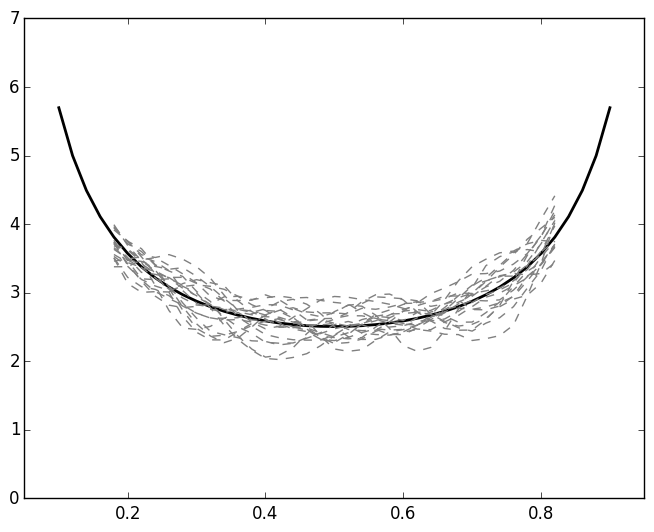

In [29]:
diffH = 2
numTau = length(tauArr)
d = Normal()
true_sp_f = 1. ./ pdf(d, quantile(d, tauArr))
plot(tauArr, true_sp_f, linestyle="-", color="black", linewidth=2.0)
ax = gca()
ax[:set_ylim]([0., 7])
ax[:set_xlim]([0.05, 0.95])
for i=1:20
    plot(tauArr[2*diffH+1:numTau-2*diffH], collect_res[i][3][2*diffH+1:numTau-2*diffH, 1], linestyle="--", color="gray", linewidth=1.0)
end

In [30]:
@everywhere function collect_spF(rep) 
    tauArr = [0.1:0.02:0.9]
    lambdaArr = logspace(log10(0.4), log10(0.05), 30)

    diffH = 1
    dataPath = "/project/mkolar/qr" 
    simPath = "/project/mkolar/qr_spF"
    corType = 2
    noiseType = 1
    
    estimated_spF(
        rep, length(tauArr), length(lambdaArr); 
        diffH = diffH,    
        dataPath = dataPath,
        simPath = simPath, 
        corType = corType,
        noiseType = noiseType)    
end
collect_res = pmap(collect_spF, [1:15]);

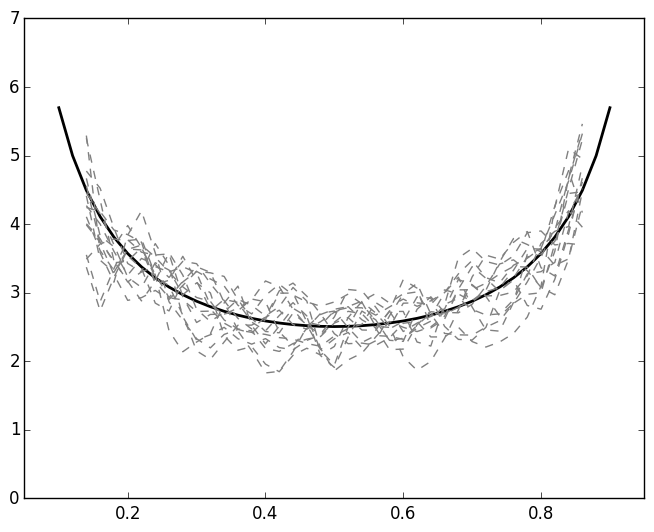

In [32]:
diffH = 1
numTau = length(tauArr)
d = Normal()
true_sp_f = 1. ./ pdf(d, quantile(d, tauArr))
plot(tauArr, true_sp_f, linestyle="-", color="black", linewidth=2.0)
ax = gca()
ax[:set_ylim]([0., 7])
ax[:set_xlim]([0.05, 0.95])
for i=1:15
    plot(tauArr[2*diffH+1:numTau-2*diffH], collect_res[i][3][2*diffH+1:numTau-2*diffH, 1], linestyle="--", color="gray", linewidth=1.0)
end

In [41]:
@everywhere function collect_spF(rep) 
    tauArr = [0.1:0.02:0.9]
    lambdaArr = logspace(log10(0.4), log10(0.05), 30)

    diffH = 4
    dataPath = "/project/mkolar/qr" 
    simPath = "/project/mkolar/qr_spF"
    corType = 2
    noiseType = 1
    
    estimated_spF(
        rep, length(tauArr), length(lambdaArr); 
        diffH = diffH,    
        dataPath = dataPath,
        simPath = simPath, 
        corType = corType,
        noiseType = noiseType)    
end
collect_res = pmap(collect_spF, [1:45]);

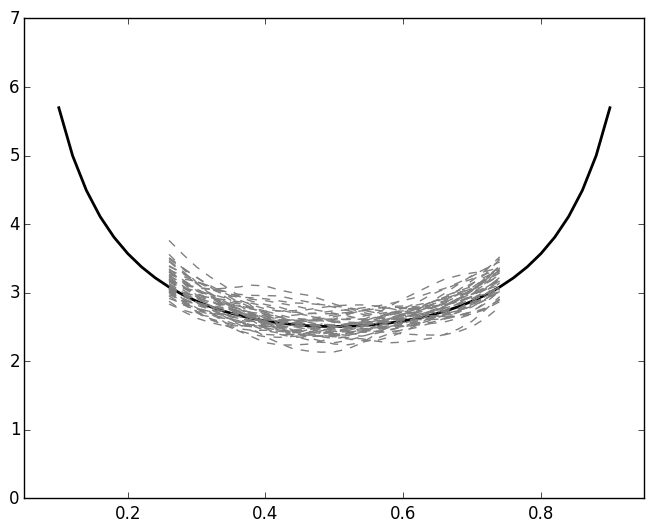

In [42]:
diffH = 4
numTau = length(tauArr)
d = Normal()
true_sp_f = 1. ./ pdf(d, quantile(d, tauArr))
plot(tauArr, true_sp_f, linestyle="-", color="black", linewidth=2.0)
ax = gca()
ax[:set_ylim]([0., 7])
ax[:set_xlim]([0.05, 0.95])
for i=1:45
    plot(tauArr[2*diffH+1:numTau-2*diffH], collect_res[i][3][2*diffH+1:numTau-2*diffH, 1], linestyle="--", color="gray", linewidth=1.0)
end

In [80]:
@everywhere function collect_spF(rep) 
    tauArr = [0.1:0.02:0.9]
    lambdaArr = logspace(log10(0.4), log10(0.05), 30)

    diffH = 3
    dataPath = "/project/mkolar/qr" 
    simPath = "/project/mkolar/qr_spF"
    corType = 2
    noiseType = 3
    
    estimated_spF(
        rep, length(tauArr), length(lambdaArr); 
        diffH = diffH,    
        dataPath = dataPath,
        simPath = simPath, 
        corType = corType,
        noiseType = noiseType)    
end
collect_res = pmap(collect_spF, [1:15]);

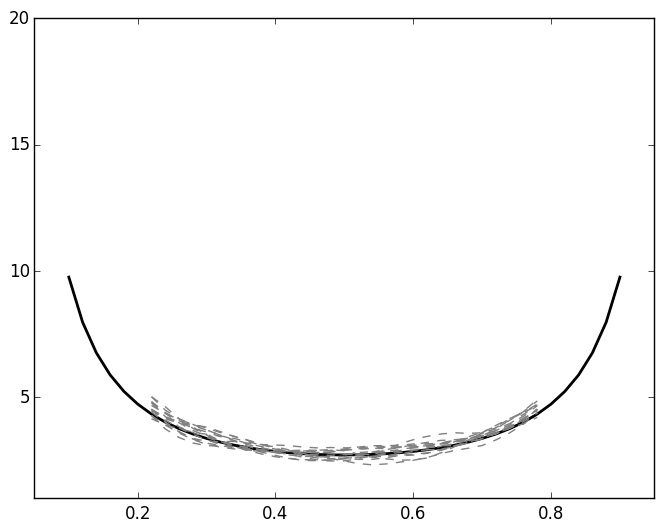

In [81]:
diffH = 3
numTau = length(tauArr)
# d = Normal()
d = TDist(3)
true_sp_f = 1. ./ pdf(d, quantile(d, tauArr))
plot(tauArr, true_sp_f, linestyle="-", color="black", linewidth=2.0)
ax = gca()
ax[:set_ylim]([1., 20])
ax[:set_xlim]([0.05, 0.95])
for i=1:15
    plot(tauArr[2*diffH+1:numTau-2*diffH], collect_res[i][3][2*diffH+1:numTau-2*diffH, 1], linestyle="--", color="gray", linewidth=1.0)
end

### Plot debiased estimators

Not clear how to select lamdbda here

In [82]:
numLines = 15
tauArr = [0.1:0.02:0.9]
lambdaArr = logspace(log10(0.4), log10(0.05), 30)
numTau = length(tauArr)
    
collect_res = pmap(x -> estimated_spF(x, 41, 30; 
        diffH = 3,    
        dataPath = "/project/mkolar/qr",
        simPath = "/project/mkolar/qr_spF", 
        corType = 2,
        noiseType = 2), 
        [1:numLines]);

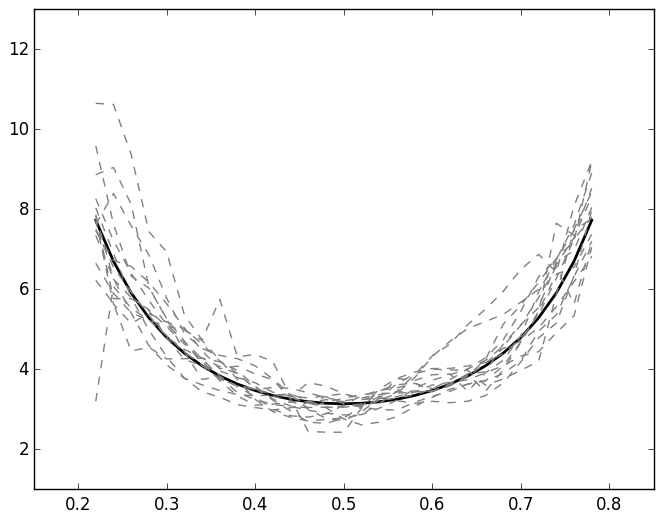

In [86]:
# d = Normal()
d = TDist(1)
diffH = 3
true_sp_f = 1. ./ pdf(d, quantile(d, tauArr))
plot(tauArr[2*diffH+1:numTau-2*diffH], true_sp_f[2*diffH+1:numTau-2*diffH], linestyle="-", color="black", linewidth=2.0)
ax = gca()
ax[:set_ylim]([1., 13])
ax[:set_xlim]([0.15, 0.85])
for i=1:numLines
    plot(tauArr[2*diffH+1:numTau-2*diffH], collect_res[i][2][2*diffH+1:numTau-2*diffH, 25], linestyle="--", color="gray", linewidth=1.0)
end

In [ ]:
tauArr = [0.1:0.02:0.9]
lambdaArr = logspace(log10(0.4), log10(0.05), 30)

estim_spf = zeros(Float64, length(tauArr), length(lambdaArr))
estim_debias_spf = zeros(Float64, length(tauArr), length(lambdaArr))
estim_oracle_spf = zeros(Float64, length(tauArr), 1)
num_res = zeros(Float64, length(tauArr), length(lambdaArr))
num_res_o = zeros(Float64, length(tauArr), 1)

In [87]:
for i=1:500
    estim_spf = estim_spf + collect_res[i][1]
    estim_debias_spf = estim_debias_spf + collect_res[i][2]
    estim_oracle_spf = estim_oracle_spf + collect_res[i][3]
    num_res = num_res + collect_res[i][4]
    num_res_o = num_res_o + collect_res[i][5]
end
for indT = 1:length(tauArr)
    for indL = 1:length(lambdaArr)
        if num_res[indT, indL] > 0
            estim_spf[indT, indL] /= num_res[indT, indL]
            estim_debias_spf[indT, indL] /= num_res[indT, indL]
        end
    end
    if num_res_o[indT, 1] > 0
        estim_oracle_spf[indT, 1] /= num_res_o[indT, 1]
    end
end

## Computing coverage

In [27]:
@everywhere function loadF(rep) 
    lambdaQRArr = logspace(log10(0.4), log10(0.05), 30)
    lambdaLassoArr = logspace(log10(0.8), log10(0.1), 30)
    tauArr = [0.3:0.02:0.7]
    indTau = findfirst(tauArr,0.3)
    indJ = 1
    
    simPath = "/scratch/midway/mkolar/qr"    
    corType = 2
    noiseType = 1
    
    compute_coverage_refit_known_f(
        lambdaQRArr, lambdaLassoArr, tauArr, rep, indTau, indJ;
        simPath = simPath, 
        corType = corType,
        noiseType = noiseType)    
end

In [28]:
numRep = 100
colRes = pmap(loadF, [1:numRep]);

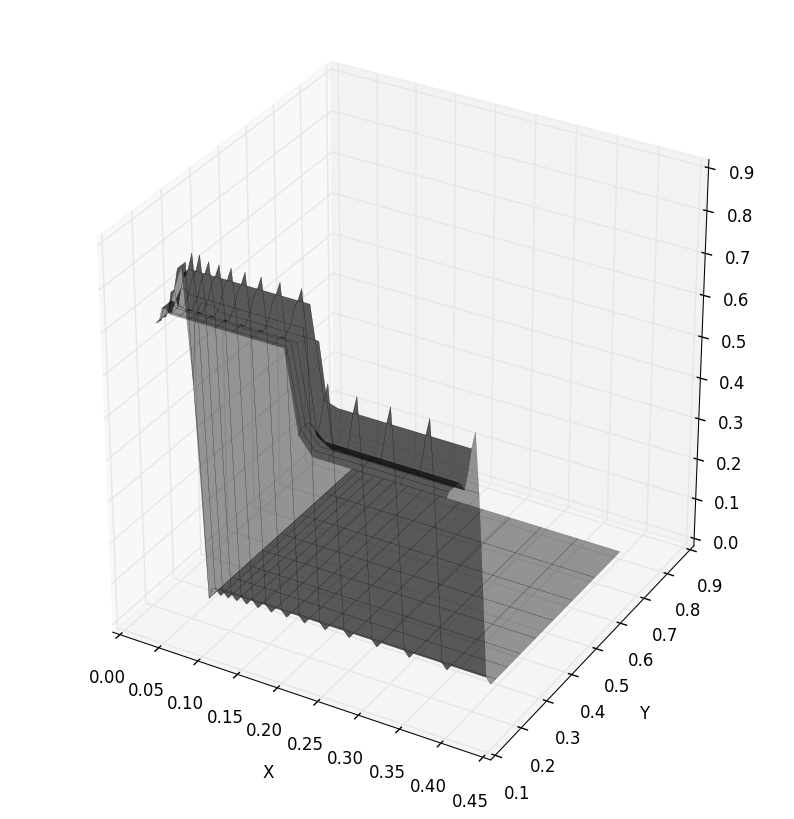

PyObject <matplotlib.text.Text object at 0x7fd815c8b110>

In [29]:
agr_num_covered = zeros(30, 30)
agr_num_appear = zeros(30, 30)

for j=1:numRep
    agr_num_covered += colRes[j][1]
    agr_num_appear += colRes[j][2]
end

tmp = agr_num_covered ./ agr_num_appear

xgrid = repmat(logspace(log10(0.4), log10(0.05), 30)', 30, 1)
ygrid = repmat(logspace(log10(0.8), log10(0.1), 30), 1, 30)

fig = figure("pyplot_surfaceplot",figsize=(10,10))
ax = fig[:add_subplot](1,1,1, projection = "3d") 
ax[:plot_surface](xgrid, ygrid, tmp, rstride=2,edgecolors="k", cstride=2, cmap=ColorMap("gray"), alpha=0.4, linewidth=0.25) 
xlabel("X") 
ylabel("Y")

In [32]:
tmp[15:25, 20:30]

11x11 Array{Float64,2}:
 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0       0.0        0.0       NaN
 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0       0.0        0.0       NaN
 0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.030303  0.0273973  0.0       NaN
 0.37  0.37  0.37  0.37  0.37  0.37  0.37  0.373737  0.383562   0.333333  NaN
 0.73  0.73  0.73  0.74  0.74  0.74  0.74  0.717172  0.684932   0.541667  NaN
 0.85  0.85  0.85  0.85  0.85  0.86  0.86  0.858586  0.835616   0.833333  NaN
 0.83  0.83  0.83  0.83  0.83  0.83  0.83  0.828283  0.808219   0.833333  NaN
 0.82  0.82  0.82  0.82  0.82  0.82  0.83  0.828283  0.794521   0.833333  NaN
 0.79  0.79  0.79  0.79  0.79  0.79  0.8   0.79798   0.753425   0.791667  NaN
 0.78  0.78  0.78  0.78  0.78  0.78  0.79  0.787879  0.767123   0.791667  NaN
 0.77  0.77  0.77  0.77  0.77  0.77  0.78  0.777778  0.753425   0.75      NaN

Kill Workers

In [ ]:
rmprocs(workers())

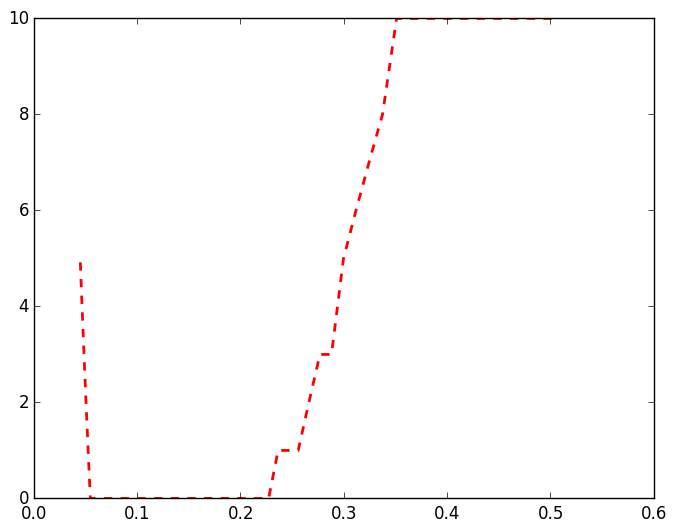

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb396a4a450>

In [105]:
h_dist = zeros(100)
num_exp = zeros(100)
s = 10
numRep = 90
for rep=1:numRep
    cur_qr_path = simRes[1]["qr_tau_path"][indTau]
    for indLambda=1:length(cur_qr_path.lambdaArr)
        estim_support = find(cur_qr_path.beta[indLambda])
        h_dist[indLambda] += length(setdiff(1:s, estim_support)) + length(setdiff(estim_support, 1:s))
        num_exp[indLambda] += 1
    end    
end

plot(lambdaArr, h_dist ./ num_exp, color="red", linewidth=2.0, linestyle="--")

## For Debugging

In [9]:
simPath = "/scratch/midway/mkolar/qr1"
rep = 1
corType = 2
noiseType = 1

lambdaQRArr = linspace(0.4, 0.0, 100)
lambdaLassoArr = linspace(0.8, 0.05, 100)
tauArr = [0.3:0.02:0.7]
indTau = findfirst(tauArr,0.5)
indJ = 10


data = JLD.load("$(simPath)/data/data_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld")
X = data["X"]
Y = data["Y"]
s = data["s"]
true_beta = data["beta"]

tau = 0.5
err_d = Normal()
spF = 1. / pdf(err_d, 0 )

n, p = size(X)

result = JLD.load("$(simPath)/path_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld");

In [11]:
hSigma = X'*X / n

residuals = Array(Float64, n)
g = Array(Float64, p)

num_covered = zeros(length(lambdaQRArr), length(lambdaLassoArr))
num_appear = zeros(length(lambdaQRArr), length(lambdaLassoArr))

cur_qr_path = result["qr_tau_path"][indTau]
cur_lasso_path = result["lasso_var_path"][indJ];

In [22]:
@show lambdaQRArr[95]
cur_qr_path.beta[95]

lambdaQRArr[95] => 0.020202020202020204


100x1 sparse matrix with 16 Float64 entries:
	[1  ,   1]  =  0.919943
	[2  ,   1]  =  0.981416
	[3  ,   1]  =  0.739849
	[4  ,   1]  =  0.608789
	[5  ,   1]  =  0.505494
	[22 ,   1]  =  -0.0235629
	[24 ,   1]  =  -0.00940574
	[35 ,   1]  =  -0.0119907
	[49 ,   1]  =  0.00966997
	[57 ,   1]  =  -0.00361409
	[58 ,   1]  =  -0.0144407
	[72 ,   1]  =  0.0126296
	[76 ,   1]  =  0.00595938
	[79 ,   1]  =  0.0269848
	[83 ,   1]  =  -0.0172218
	[90 ,   1]  =  -0.00814166

In [42]:
estim_support_lasso = find(cur_lasso_path.beta[indL2])
refit_lasso = result["lasso_refit_var_path"][indJ][estim_support_lasso]

2-element Array{Float64,1}:
  2.78076
 -2.16707

In [43]:
for i=1:n
    tmp = Y[i] - refit_qr.intercept - dot(vec(X[i, refit_qr.beta.rowval]), refit_qr.beta.nzval)
    if tmp < 0.
        residuals[i] = tau - 1
    else
        residuals[i] = tau
    end
end
At_mul_B!(g, X, residuals)    

hb_debias = refit_qr.beta[indJ] + dot(refit_lasso, g[estim_support_lasso]) * spF / n

0.9828877467764753

In [53]:
refit_lasso' * g[estim_support_lasso] * spF / n

1-element Array{Float64,1}:
 -0.00286327

In [54]:
eSigma = dot(refit_lasso, hSigma[estim_support_lasso, estim_support_lasso] * refit_lasso) * tau * (1 - tau) * spF^2 / n

0.004368003917468316

In [56]:
lb = hb_debias - 1.96 * sqrt( eSigma )
ub = hb_debias + 1.96 * sqrt( eSigma )
lb, ub

(0.8533496294158069,1.1124258641371436)

In [39]:


for indL1=1:length(cur_qr_path.lambdaArr)
    estim_support_qr = find(cur_qr_path.beta[indL1])
    refit_qr = result["qr_refit_tau_path"][indTau][estim_support_qr]

    for indL2=1:length(cur_lasso_path.lambdaArr)
        estim_support_lasso = find(cur_lasso_path.beta[indL2])
        refit_lasso = result["lasso_refit_var_path"][indJ][estim_support_lasso]

        for i=1:n
            tmp = Y[i] - refit_qr.intercept - dot(vec(X[i, refit_qr.beta.rowval]), refit_qr.beta.nzval)
            if tmp < 0.
                residuals[i] = tau - 1
            else
                residuals[i] = tau
            end
        end
        At_mul_B!(g, X, residuals)              

        hb_debias = refit_qr.beta[indJ] + dot(refit_lasso, g[estim_support_lasso]) * spF / n
        eSigma = dot(refit_lasso, hSigma[estim_support_lasso, estim_support_lasso] * refit_lasso) * tau * (1 - tau) * spF^2    
        lb = hb_debias - 1.96 * sqrt( eSigma )
        ub = hb_debias + 1.96 * sqrt( eSigma )

        num_appear[indL1, indL2] += 1
        if (lb < true_beta[indJ] < ub)
            num_covered[indL1, indL2] += 1
        end

    end
end

## Testing Parallel

In [1]:
@everywhere function generate_rnd(rep)
    srand(rep)
    randn()
end

In [6]:
res = pmap(generate_rnd, [1:10])

10-element Array{Any,1}:
  0.297288  
  0.739621  
  1.19156   
 -1.76112   
  1.46431   
 -1.314     
  1.39509   
 -0.00762343
 -1.03324   
 -0.15548   